In [1]:
import model as m 
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import scipy
import math

In [2]:
age_class = ["<1", "1-4", "5-9", "10-14", "15-19", "20-29", "30+"]
#Select disease
d = "Measles"

#monthly data
data = pd.read_csv( d +'_data_processed.csv')
monthly_data = data.iloc[:,1:8]
monthly_data = monthly_data[age_class]

#I do not consider 2019
monthly_data = monthly_data.iloc[0:(data.shape[0]-12),:]

time_date = data["Time"][0:(data.shape[0]-12)]

if d== "Mumps":
    years_run = int(time_date[len(time_date)-1]) - int(time_date[0]) +1
    start_yr = int(time_date[0])
    end_yr = int(time_date[len(time_date)-1])
     
else:
    start_yr = int(time_date[0][0:4])
    end_yr = int(time_date[len(time_date)-1][0:4])
    years_run = int(time_date[len(time_date)-1][0:4]) - int(time_date[0][0:4]) +1

print(start_yr)
print(end_yr)
print(years_run, "--> tmax")

1999
2018
20 --> tmax


### Extracting birth and death rates for age groups:

* Death rates: *death_rate_7_age_groups_1982-2018.csv*: 
$$ d_i = \frac{\text{number of death people who are in i-th age group}}{\text{population in i-th age group}}$$
* Births: *Crude_birth_rate_1938-2018.csv*, unit is birth number per 1000 population
* Population: *population_7_age_groups_1982-2018.csv*

In [3]:
##### Births
Births = pd.read_csv("Data//Crude_birth_rate_1938-2018.csv")

#Select from year 1999 to 2018
if d == "Mumps":
    Births_years = Births.iloc[0:(end_yr-start_yr+1),:]
else:
    Births_years = Births.iloc[0:(end_yr-start_yr+1),:]

#Selecting 3rd column for UK data
Births_years_UK = Births_years.iloc[:,2] 

Births_UK =  Births_years_UK.to_numpy()
#We shall reverse the order to go from 1999 to 2018

Births_UK = np.asarray(list(reversed(Births_UK)))/1000 # Normalise to per capita
#### Deaths
Deaths = pd.read_csv("Data//death_rate_7_age_groups_1982-2018.csv")

#exclude last row (no total)
Deaths = Deaths.iloc[0:7,:]

#Selecting columns for years 1999-2018

Deaths_years = Deaths.iloc[:,np.where(Deaths.columns== str(start_yr))[0][0]:np.where(Deaths.columns==str(end_yr))[0][0]+1]

#### Population
Pops = pd.read_csv("Data//population_7_age_groups_1982-2018.csv")

#Just need last row

Pops_tot = Pops.iloc[7,np.where(Deaths.columns==str(start_yr))[0][0]:np.where(Deaths.columns==str(end_yr))[0][0]+1]

#print(Pops_tot)

Pops_tot = np.asarray(Pops_tot)

##### Including real contact matrix from Polymod

- equally weighted one

In [4]:
Poly_7_new = pd.read_csv("Data/Poly_7.csv")
Poly_7_new = Poly_7_new.iloc[:,1:8]
Poly_7_new = Poly_7_new.iloc[np.hstack([6, np.arange(0,6)]),:]
C_poly = Poly_7_new.values

#### Vaccine coverage and Vaccinated IC

In [5]:
Cov_rate = pd.read_csv("Data//" +d +'_vaccine_coverage.csv')
V_ic = Cov_rate.iloc[0:7,1:2]
V_ic = V_ic.to_numpy().reshape((7,))/100
Cov_rate_years = Cov_rate.iloc[0:7,2:21]

# Issue: vaccination rate is up until 2016, now assume 2017-19 are the same?
Cov_rate_years["2017"] = Cov_rate_years["2018"]  = Cov_rate_years["2016"]

Cov_rate_years = Cov_rate_years.iloc[:,np.where(Cov_rate_years.columns== str(start_yr))[0][0]:np.where(Cov_rate_years.columns==str(end_yr))[0][0]+1]
Shift_cov_rate_years = Cov_rate_years.iloc[np.hstack([6, np.arange(0,6)]),:]

In [6]:
from multiprocessing import Process, Array

def get_yearly_rates(Y_N, eval_per_year, n_years):
        return np.diff(Y_N[:,np.linspace(0, (eval_per_year-1)*n_years, n_years, dtype=np.int32)])

def get_monthly_rates(Y_N, eval_per_year, n_years):
        return np.diff(Y_N[:,np.linspace(0, (eval_per_year-1)*n_years, 12*n_years, dtype=np.int32)])
                       
def f_ssq(beta_vec):
    n_eval=120
    beta = np.eye(7)*np.maximum(beta_vec,0.0010)
    mdl = m.SIRVModel(para, lambda t: beta)
    
    ic = estimate_SIR_IC(mdl, age_struct_start, pop_scale, V_ic)    
    
    if d == "Mumps":
        out, t, out_YN = mdl.run(ic ,t_max = years_run-0.0001,method="RK45", eval_per_year=n_eval, pop_scale=pop_scale, atol =1e-6, rtol = 1e-3)
        new_inf = get_yearly_rates(out_YN, n_eval, years_run)
    else:
        out, t, out_YN = mdl.run(ic ,t_max = years_run-0.0001,method="RK45", eval_per_year=n_eval, pop_scale=pop_scale, atol =1e-6, rtol = 1e-3)
        new_inf = get_monthly_rates(out_YN, n_eval, years_run)
    
    ssq = np.sum(np.sum((new_inf*((1/pop_scale)*1e5)-np.reshape(monthly_data[age_class].to_numpy()[0:-1], (7,-1)))**2))
    print("Loss: "+str(ssq)+" Beta: "+str(beta_vec))
    return ssq

def f_ssq_wrapper(beta_vec, ret):
    ret[0] = f_ssq(beta_vec)

def f_ssq_timeout(beta_vec):
    val = Array('d',1)
    p = Process(target=f_ssq_wrapper, args = (beta_vec,val,))
    p.start()
    p.join(30)
    if p.is_alive():
        print("Maximum computation time exceeded")
        p.terminate()
        p.join()
        return 1e100
    else:
        return val[0]

Each age group IC is weighted by their percetange at first year pop

In [7]:
def estimate_SIR_IC(mdl, age_struct, pop_scale, V_ic, eps_I = 1e-6, k=7):
    ###Start with a population where anyone who isnt vaccinated is susceptible 
    #(+eps_I level of infections))
    S_ic = (np.ones(k)-V_ic)*(1-eps_I)
    I_ic = (np.ones(k)-V_ic-S_ic)*[1,1,1,1,1,1,1]
    R_ic = (np.ones(k) - S_ic - I_ic - V_ic)
    
    #Normalise profile
    norm_ic = np.hstack([S_ic*age_struct_start,  
                    I_ic*age_struct_start,
                    R_ic*age_struct_start,
                    V_ic*age_struct_start])*pop_scale
    
    ### Run for a year
    out, t, out_YN = mdl.run(norm_ic, 
                             t_max = 1.0,
                             method="RK45",
                             eval_per_year=120,
                             pop_scale=pop_scale, atol=1e-3, rtol=1e-4)
    
    ### Note this only works for sensible betas and gammas 
    ###(i.e. assumes epidemic over in a year)
    level_estimate = out[:, -1]
    
    S_level = level_estimate[0:k]
    I_level = level_estimate[k:2*k]
    R_level = level_estimate[2*k:3*k]
    
    S_const = S_level/(S_level+I_level+R_level)
    I_const = I_level/(I_level+R_level)
    
    S_ic_est = (np.ones(k)-V_ic)*S_const
    I_ic_est = (np.ones(k)-V_ic-S_ic_est)*I_const
    R_ic_est = (np.ones(k)-V_ic-S_ic_est-I_ic_est)
    
    estimated_IC = np.hstack([S_ic_est*age_struct_start,
                              I_ic_est*age_struct_start,
                              R_ic_est*age_struct_start,
                              V_ic*age_struct_start])*1000
        
    return(estimated_IC)    

In [8]:
#Prepare Model Parameters
pop_scale = 1000 #Set scale to cases per 1000 
age_struct_start = np.asarray(Pops[str(start_yr)][0:7]/np.sum(Pops[str(start_yr)][0:7]))

para = m.ModelParams(
    age_strucure=[0,1, 5, 10, 15, 20, 30],  #age cuts
    B= lambda t: (Births_UK*pop_scale)[int(np.floor(t))],  #births rate per 1000
    V=lambda t: (Shift_cov_rate_years.to_numpy()/100.0)[:, (int(np.floor(t))-1)],
    d=lambda t: Deaths_years.to_numpy()[:, int(np.floor(t))],  #death rate per capita
    gamma=(1/7*365.0)*np.ones([7]),
    C=C_poly*365,
    N= lambda t: Pops_tot[int(np.floor(t))]
)


### Setting correct recovery rate

* Measles: recovery period of 7 - 10 days
* Mumps: 1 to 2 weeks
* Rubella: 3 days 

In [9]:
if d == "Measles":
    para.gamma = (1/8.5 *365.0)*np.ones([7]) #I compute the average
elif d == "Mumps":
    para.gamma = (1/10.5 *365.0)*np.ones([7])
elif d == "Rubella":
    para.gamma = (1/3 *365.0)*np.ones([7])

[0.10595444 0.28896667 0.49470556 0.23575556 0.10261111 0.10225556
 0.33785556]


Text(0.5, 1.0, 'Monthly infections per 100K')

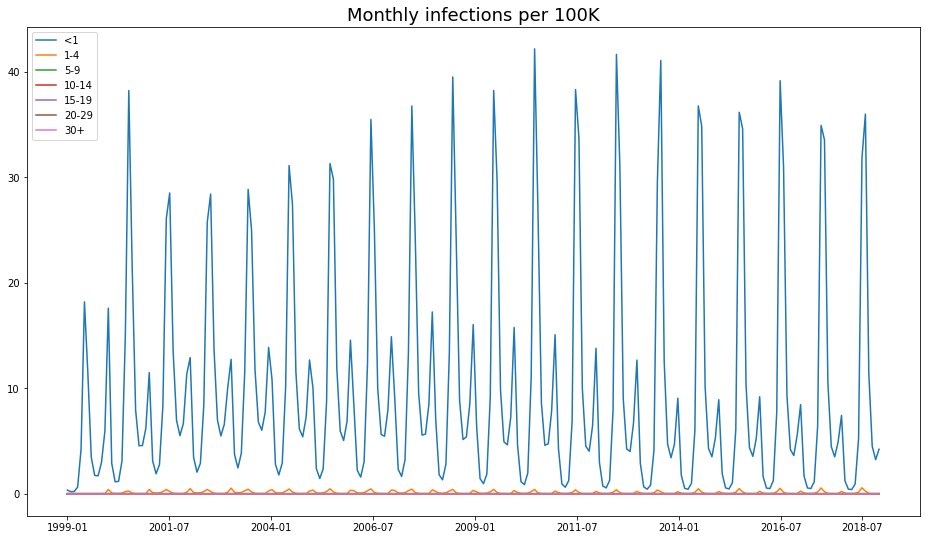

In [10]:
beta = np.eye(7)*[0.022,0.06,0.07,0.04, 0.02,0.02,0.02]

print((beta@para.C/365)@np.ones(7))


mdl = m.SIRVModel(para, lambda t: beta)
ic = estimate_SIR_IC(mdl, age_struct_start, pop_scale, V_ic)

eval_year = 120
out, t, out_YN = mdl.run(ic ,t_max = years_run-0.00001, method="RK45", eval_per_year=eval_year, pop_scale=pop_scale, 
                         atol=1e-6, rtol = 1e-4)
"""""
Inf_OUT = out[7:(7*2),:]
plt.figure(figsize=(16,9))
for ii in range(7):
    plt.plot(t[0:len(t)], np.transpose(out[7+ii,0:len(t)]), label = age_class[ii])
plt.legend()
plt.title("Infected curve for all age groups (unnormalized)", fontsize = 18)
"""

plt.figure(figsize=(16,9))
for ii in range(7):
    plt.plot(np.linspace(0,years_run, years_run*12)[0:-1], 
             (1e5/pop_scale)*np.transpose(get_monthly_rates(out_YN, eval_year, years_run)[ii,:]), label = age_class[ii])

locs, labels = plt.xticks()
locs = np.hstack([locs[1:-2], 19.5])
plt.xticks(locs, time_date[locs*12])
plt.legend()
plt.title("Monthly infections per 100K", fontsize = 18)


Text(0.5, 1.0, 'Monthly infections per 100K')

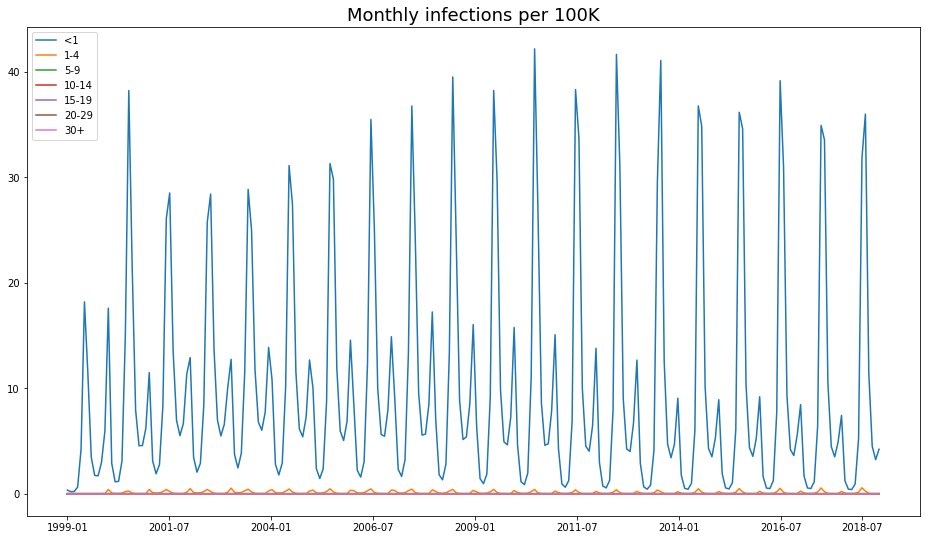

In [11]:
plt.figure(figsize=(16,9))
for ii in range(7):
    plt.plot(np.linspace(0,years_run, years_run*12)[0:-1], 
             (1e5/pop_scale)*np.transpose(get_monthly_rates(out_YN, eval_year, years_run)[ii,:]), label = age_class[ii])

locs, labels = plt.xticks()
locs = np.hstack([locs[1:-2], 19.5])
plt.xticks(locs, time_date[locs*12])
plt.legend()
plt.title("Monthly infections per 100K", fontsize = 18)


NameError: name 'My_Time' is not defined

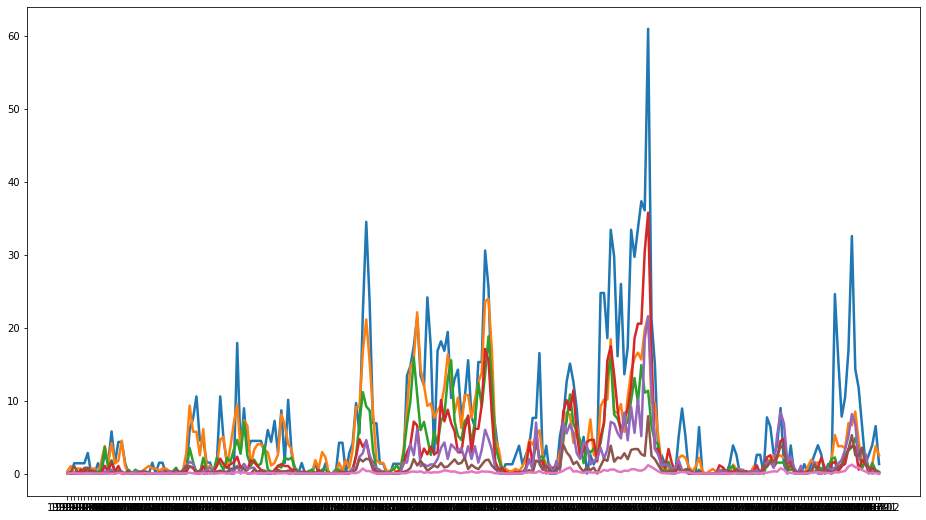

In [13]:
for d in ['Measles']:
#for d in ['Measles']:
    #option for dotted in Mumps
    if d == "Mumps":
        fig = plt.figure(figsize=(16,9))
        for cc in age_class:
            plt.plot(time_date, monthly_data[cc], "-o", markersize = 7, lw = 2.5, label= cc)
        plt.xticks(fontsize = 18)
        plt.yticks(fontsize = 18)
    else:
        fig = plt.figure(figsize=(16,9))
        for cc in age_class:
            plt.plot(time_date, monthly_data[cc], lw = 2.5, label= cc)
        step_loc = math.floor(len(My_Time)/8)
        locs = np.arange(0, 9) * step_loc

        plt.yticks(fontsize = 18)
        #plt.xticks(locs, My_Time.loc[locs][0], fontsize = 18)
            
    plt.xlabel("Time", fontsize=18)
    plt.legend(shadow= True, fontsize = 19)
    plt.title(d+" Cases Per 100k", fontsize = 20)
    #svg better for Poster
    
    #plt.savefig(d+"Plot.svg")
    #plt.figure(figsize=(16,9))
    for ii in range(7):
        plt.plot(time_date[0:len(time_date)-1], 
                 (1e5/pop_scale)*np.transpose(get_monthly_rates(out_YN, eval_year, years_run)[ii,:]), label = age_class[ii])
    plt.legend()
    #plt.title("Monthly infections per 100K", fontsize = 18)


## Plotting the scaled infected by normalising pop

In [ ]:
Inf_OUT = out[7:(7*2),:]
plt.figure(figsize=(16,9))
for ii in range(7):
    tot = np.sum(out[np.array([0,7,14,21])+ii,], axis=0)
    plt.plot(t[0:len(t)], (np.transpose(out[7+ii,]) / tot)[0:len(t)]*100, label = age_class[ii])
plt.legend()
if d == "Mumps":
    plt.xticks(t[0:len(t)][np.arange(years_run)*eval_year], time_date)
else:
    plt.xticks(t[0:len(t)][np.arange(years_run)*eval_year], time_date[np.arange(1, years_run)*12])

plt.title("Infected curve for all age groups (normalized per 100k)", fontsize = 18)

if d == "Mumps":
    plt.savefig("Inf_sim_"+d+"_noOpt.svg")

In [14]:
#fit_measles = scipy.optimize.fmin(f_ssq_timeout, x0 = np.array([0.0025,  0.25185257,  0.8639866 ,  0.74971919,  0.7785915 ,
#        1.57351055,  0.51410717]), xtol=1e-4
#                                  ,maxiter = 2000, maxfun = 2000, full_output=1)

fit_measles = scipy.optimize.fmin(f_ssq_timeout, x0 = np.array([0.08,0.15,0.2,0.2, 0.2,0.2,0.2]), xtol=1e-6,maxiter = 2000, maxfun = 2000, full_output=1)

Loss: 207019.57974122785 Beta: [0.08 0.15 0.2  0.2  0.2  0.2  0.2 ]
Loss: 214835.4122760839 Beta: [0.084 0.15  0.2   0.2   0.2   0.2   0.2  ]
Loss: 207071.31536642255 Beta: [0.08   0.1575 0.2    0.2    0.2    0.2    0.2   ]
Loss: 207019.53714196553 Beta: [0.08 0.15 0.21 0.2  0.2  0.2  0.2 ]
Loss: 207019.5802273276 Beta: [0.08 0.15 0.2  0.21 0.2  0.2  0.2 ]
Loss: 207020.04764296673 Beta: [0.08 0.15 0.2  0.2  0.21 0.2  0.2 ]
Loss: 207020.3077730043 Beta: [0.08 0.15 0.2  0.2  0.2  0.21 0.2 ]
Loss: 207018.43790095876 Beta: [0.08 0.15 0.2  0.2  0.2  0.2  0.21]
Loss: 199471.77818511447 Beta: [0.076      0.15214286 0.20285714 0.20285714 0.20285714 0.20285714
 0.20285714]
Loss: 192414.14399317157 Beta: [0.072      0.15321429 0.20428571 0.20428571 0.20428571 0.20428571
 0.20428571]
Loss: 202609.2069997201 Beta: [0.07771429 0.14341837 0.20408163 0.20408163 0.20408163 0.20408163
 0.20408163]
Loss: 201417.6947715594 Beta: [0.07706122 0.1490379  0.20524781 0.20524781 0.20524781 0.19239067
 0.205247

 0.27258663]
Loss: 59741.927661324415 Beta: [0.00761438 0.14548231 0.21155012 0.24259132 0.2059756  0.23254084
 0.27267489]
Maximum computation time exceeded
Loss: 61343.01204378106 Beta: [0.00877148 0.14546684 0.21097445 0.24067308 0.20579421 0.232189
 0.27260697]
Loss: 59733.16998723911 Beta: [0.00780821 0.14339722 0.21124597 0.24247105 0.20546381 0.23114853
 0.274713  ]
Maximum computation time exceeded
Loss: 61111.2177655559 Beta: [0.00849286 0.14580192 0.21162312 0.24102035 0.20533329 0.23171608
 0.27272907]
Maximum computation time exceeded
Loss: 60245.98466528164 Beta: [0.00852559 0.1450989  0.21099561 0.24096923 0.20575089 0.23216529
 0.27303683]
Maximum computation time exceeded
Loss: 60262.140332332594 Beta: [0.00838862 0.14507569 0.21104233 0.24119396 0.20579019 0.23218026
 0.27307771]
Maximum computation time exceeded
Loss: 60088.54136538891 Beta: [0.00824186 0.14519135 0.21132518 0.24138    0.20559236 0.23197696
 0.27316366]
Maximum computation time exceeded
Loss: 59985.92

 0.27199666]
Loss: 59617.17868057041 Beta: [0.00780135 0.14392068 0.21224298 0.24211477 0.2063062  0.23331992
 0.2719916 ]
Loss: 59715.73328294729 Beta: [0.00779544 0.14391925 0.21228678 0.24212703 0.20631008 0.23333692
 0.27194023]
Maximum computation time exceeded
Loss: 59614.87622267137 Beta: [0.00779485 0.14392451 0.21224263 0.2421308  0.20630557 0.23331494
 0.27199682]
Loss: 59615.16605957977 Beta: [0.0077953  0.14390843 0.21224659 0.24212768 0.20630736 0.23331892
 0.27199717]
Loss: 59614.95535820171 Beta: [0.00779791 0.14391996 0.21224271 0.24212157 0.20630685 0.23331964
 0.27199429]
Loss: 59618.30707181211 Beta: [0.00779522 0.14391748 0.21224629 0.24212764 0.20630254 0.23331051
 0.27200021]
Loss: 59619.4207545986 Beta: [0.00779608 0.14391486 0.21224448 0.24212734 0.20630386 0.23331194
 0.27200113]
Loss: 59618.61327288618 Beta: [0.00779684 0.14391105 0.21224502 0.24212989 0.2063052  0.23331238
 0.27199975]
Maximum computation time exceeded
Maximum computation time exceeded
Loss: 

 0.27200749]
Loss: 59604.95588387282 Beta: [0.00776003 0.14389976 0.21227417 0.24220777 0.20630473 0.23330184
 0.27200425]
Loss: 59602.88723867691 Beta: [0.00775469 0.14390271 0.21227741 0.24221977 0.20630415 0.2332992
 0.27200447]
Loss: 59602.04075697496 Beta: [0.00775322 0.14390611 0.21227783 0.24222273 0.20630392 0.2332987
 0.27200383]
Loss: 59602.49904913325 Beta: [0.00775514 0.14389966 0.21228157 0.24221982 0.20630235 0.2332963
 0.2720036 ]
Loss: 59621.30506534288 Beta: [0.00774578 0.14390026 0.21228412 0.24224128 0.2063033  0.23329385
 0.27200706]
Loss: 59604.111618774885 Beta: [0.00775895 0.14389997 0.21227607 0.24221032 0.20630408 0.23330051
 0.27200385]
Loss: 59601.27891338548 Beta: [0.00774878 0.14390043 0.21228389 0.24223423 0.20630272 0.23329437
 0.27200548]
Loss: 59599.604690013686 Beta: [0.00774316 0.14390077 0.21228875 0.24224746 0.20630172 0.23329064
 0.27200609]
Loss: 59600.76988059182 Beta: [0.00774535 0.14390045 0.2122856  0.2422423  0.2063027  0.23329287
 0.27200652

 0.27200734]
Loss: 59596.733404193175 Beta: [0.00772312 0.14389874 0.21230989 0.24229415 0.206297   0.23327606
 0.27200711]
Loss: 59596.47716055927 Beta: [0.00772146 0.14389903 0.21231102 0.2422977  0.20629684 0.23327534
 0.27200729]
Loss: 59596.521835820386 Beta: [0.00771956 0.1438983  0.2123145  0.24230183 0.20629552 0.23327278
 0.27200727]
Loss: 59613.064333909526 Beta: [0.00772065 0.14389886 0.21231212 0.24229922 0.20629647 0.23327465
 0.27200736]
Loss: 59596.64484860776 Beta: [0.0077225  0.14389877 0.21231045 0.24229542 0.20629687 0.23327571
 0.27200717]
Loss: 59596.43950985912 Beta: [0.00771887 0.1438997  0.21231339 0.24230299 0.20629622 0.23327381
 0.27200736]
Loss: 59611.340831457914 Beta: [0.00771612 0.1439005  0.21231557 0.24230874 0.20629575 0.23327241
 0.27200748]
Loss: 59616.63580901679 Beta: [0.00771593 0.14389708 0.21231847 0.24231125 0.20629497 0.23327016
 0.27200726]
Loss: 59596.54805812206 Beta: [0.00772306 0.14389963 0.21230915 0.24229354 0.20629719 0.23327667
 0.272

 0.27200735]
Loss: 59596.34626233579 Beta: [0.00771993 0.1438986  0.21231319 0.24230101 0.20629616 0.23327386
 0.27200735]
Loss: 59612.762473375806 Beta: [0.00772004 0.14389857 0.21231309 0.24230078 0.20629618 0.23327393
 0.27200735]
Loss: 59596.42831132117 Beta: [0.00772022 0.14389842 0.21231299 0.24230054 0.20629622 0.23327397
 0.27200734]
Loss: 59596.36023714097 Beta: [0.00771972 0.14389868 0.21231337 0.24230144 0.20629611 0.23327374
 0.27200735]
Loss: 59596.42984189518 Beta: [0.00772015 0.14389846 0.21231311 0.24230052 0.20629615 0.23327392
 0.27200734]
Loss: 59596.358346727706 Beta: [0.00771977 0.14389866 0.21231331 0.2423014  0.20629614 0.23327377
 0.27200735]
Loss: 59612.71002813554 Beta: [0.00771989 0.14389851 0.21231338 0.24230111 0.20629607 0.23327371
 0.27200735]
Loss: 59596.357008869745 Beta: [0.00771988 0.14389863 0.21231321 0.24230115 0.20629617 0.23327385
 0.27200735]
Loss: 59596.43086493734 Beta: [0.00772009 0.14389848 0.21231311 0.24230075 0.20629618 0.23327389
 0.2720

 0.27200734]
Loss: 59596.287263354265 Beta: [0.00771971 0.14389452 0.21231696 0.24230279 0.20629482 0.23327112
 0.27200735]
Loss: 59596.28147786566 Beta: [0.00771967 0.14389392 0.21231753 0.24230307 0.20629462 0.2332707
 0.27200735]
Loss: 59596.2653913307 Beta: [0.00771958 0.14389284 0.21231855 0.24230358 0.20629426 0.23326996
 0.27200735]
Loss: 59596.2682116042 Beta: [0.00771953 0.14389292 0.21231853 0.2423037  0.20629428 0.23326998
 0.27200735]
Loss: 59596.26468596826 Beta: [0.00771955 0.14389273 0.21231866 0.24230371 0.20629423 0.23326989
 0.27200735]
Loss: 59596.24439054334 Beta: [0.00771943 0.14389131 0.21232    0.24230442 0.20629377 0.23326892
 0.27200735]
Loss: 59596.250785251425 Beta: [0.00771949 0.14389183 0.21231953 0.24230412 0.20629391 0.23326924
 0.27200735]
Loss: 59596.24146948072 Beta: [0.00771939 0.14389093 0.21232037 0.24230463 0.20629364 0.23326865
 0.27200735]
Loss: 59596.21394485422 Beta: [0.0077192  0.14388877 0.21232242 0.24230574 0.20629293 0.23326717
 0.27200735

 0.27200736]
Loss: 59612.00334052456 Beta: [0.00771637 0.14385444 0.21235487 0.24232282 0.20628163 0.2332437
 0.27200736]
Loss: 59595.87669741514 Beta: [0.00771652 0.14385622 0.21235318 0.24232194 0.20628222 0.23324492
 0.27200736]
Loss: 59612.00795356396 Beta: [0.00771637 0.14385448 0.21235483 0.24232283 0.20628165 0.23324373
 0.27200736]
Loss: 59595.876184701905 Beta: [0.00771652 0.14385611 0.21235329 0.24232199 0.20628218 0.23324484
 0.27200736]
Loss: 59595.86583335044 Beta: [0.0077164  0.14385473 0.21235459 0.24232268 0.20628173 0.2332439
 0.27200736]
Loss: 59612.006338557505 Beta: [0.00771637 0.14385442 0.21235488 0.24232284 0.20628163 0.23324369
 0.27200736]
Loss: 59595.8734056261 Beta: [0.00771648 0.14385577 0.21235361 0.24232216 0.20628207 0.23324461
 0.27200736]
Loss: 59612.0085301107 Beta: [0.00771637 0.14385443 0.21235487 0.24232284 0.20628163 0.2332437
 0.27200736]
Loss: 59595.872955347564 Beta: [0.00771648 0.14385569 0.21235368 0.2423222  0.20628204 0.23324456
 0.27200736]

 0.27200732]
Loss: 59593.88102993637 Beta: [0.00771947 0.14376108 0.21243077 0.24234204 0.20625422 0.23318996
 0.27200732]
Loss: 59593.33056205193 Beta: [0.00772021 0.1437315  0.21245508 0.24234873 0.20624546 0.23317271
 0.27200731]
Loss: 59593.63602686945 Beta: [0.00772003 0.14374792 0.21244129 0.24234446 0.20625042 0.23318253
 0.27200731]
Loss: 59593.4357771879 Beta: [0.00772022 0.14373707 0.21245027 0.24234712 0.2062472  0.23317616
 0.2720073 ]
Loss: 59593.165754277594 Beta: [0.0077209  0.14372186 0.2124624  0.2423498  0.20624282 0.23316761
 0.2720073 ]
Loss: 59592.52859950374 Beta: [0.00772224 0.14368183 0.21249485 0.24235803 0.20623113 0.23314466
 0.27200728]
Loss: 59592.79429272297 Beta: [0.00772123 0.14370063 0.21248004 0.24235514 0.20623651 0.23315509
 0.27200729]
Loss: 59592.532778937406 Beta: [0.00772204 0.14368267 0.21249442 0.24235828 0.20623129 0.23314493
 0.27200728]
Loss: 59592.27656293814 Beta: [0.00772222 0.14366752 0.21250708 0.24236223 0.20622675 0.23313592
 0.272007

 0.27200694]
Loss: 59583.81049021 Beta: [0.00774405 0.14285843 0.21316972 0.24254159 0.2059883  0.23266641
 0.27200695]
Loss: 59583.7020010108 Beta: [0.00774466 0.14283636 0.21318772 0.24254645 0.20598184 0.23265367
 0.27200694]
Loss: 59583.452012080124 Beta: [0.00774554 0.14279909 0.21321848 0.24255501 0.20597075 0.23263184
 0.27200692]
Loss: 59582.82385063036 Beta: [0.00774774 0.14270517 0.21329584 0.24257665 0.20594292 0.23257696
 0.27200689]
Loss: 59583.07344422263 Beta: [0.00774643 0.14275373 0.21325602 0.2425659  0.20595727 0.23260519
 0.27200691]
Loss: 59582.74122346028 Beta: [0.00774696 0.14272014 0.21328399 0.24257427 0.20594723 0.23258532
 0.2720069 ]
Loss: 59581.86082243301 Beta: [0.00774919 0.14261022 0.21337491 0.24260047 0.20591456 0.23252079
 0.27200686]
Loss: 59582.362923958455 Beta: [0.00774826 0.14266427 0.21333005 0.24258717 0.20593065 0.23255264
 0.27200688]
Loss: 59581.737345133544 Beta: [0.00774993 0.14259832 0.21338421 0.24260203 0.20591116 0.23251424
 0.27200685

 0.27200666]
Loss: 59577.852486891774 Beta: [0.00776022 0.14212236 0.21377732 0.24271382 0.2057698  0.23223527
 0.27200667]
Loss: 59647.92314875442 Beta: [0.00776098 0.14209213 0.21380218 0.24272066 0.20576085 0.23221764
 0.27200666]
Loss: 59577.84175303157 Beta: [0.00776021 0.14212196 0.21377767 0.24271396 0.20576968 0.23223502
 0.27200667]
Loss: 59577.67036361445 Beta: [0.00776082 0.1420967  0.21379847 0.24271974 0.20576219 0.23222026
 0.27200666]
Loss: 59647.88469663396 Beta: [0.00776095 0.14209075 0.21380338 0.24272112 0.20576042 0.23221678
 0.27200666]
Loss: 59577.807577311556 Beta: [0.00776037 0.14211586 0.21378268 0.24271531 0.20576787 0.23223147
 0.27200667]
Loss: 59577.62165267144 Beta: [0.00775984 0.14211852 0.21378102 0.2427159  0.20576852 0.23223259
 0.27200668]
Loss: 59648.29081217673 Beta: [0.0077606  0.14209583 0.21379945 0.24272054 0.20576186 0.23221954
 0.27200667]
Loss: 59577.78005088039 Beta: [0.00776032 0.14211573 0.21378285 0.2427155  0.20576782 0.23223134
 0.27200

 0.27200697]
Loss: 59571.0867788537 Beta: [0.00771876 0.14258867 0.21342751 0.24268355 0.20589903 0.23247987
 0.27200715]
Loss: 59578.184832005696 Beta: [0.00771571 0.14261448 0.21340899 0.24268377 0.20590597 0.23249272
 0.27200719]
Loss: 59571.6756068614 Beta: [0.00773114 0.14244068 0.2135394  0.24269512 0.20585779 0.23240153
 0.27200701]
Loss: 59577.661249996556 Beta: [0.00771647 0.14261189 0.21341034 0.24268261 0.20590541 0.23249185
 0.27200718]
Loss: 59571.49750858404 Beta: [0.00773003 0.1424512  0.21353171 0.24269488 0.20586065 0.23240689
 0.27200702]
Loss: 59570.76599510736 Beta: [0.0077183  0.14257577 0.21343899 0.24268843 0.20589499 0.23247164
 0.27200715]
Loss: 59578.16889812295 Beta: [0.00771561 0.14261132 0.21341179 0.24268493 0.20590498 0.23249072
 0.27200719]
Loss: 59571.28136711556 Beta: [0.00772726 0.14248334 0.2135075  0.24269257 0.20586959 0.23242383
 0.27200705]
Loss: 59577.9362090365 Beta: [0.00771593 0.14260999 0.21341256 0.24268451 0.20590467 0.2324902
 0.27200718]

 0.27200702]
Loss: 59566.19158143301 Beta: [0.00772152 0.14228237 0.21368486 0.24276517 0.20580691 0.23229681
 0.27200708]
Loss: 59570.459583025404 Beta: [0.00771544 0.14228044 0.21369335 0.24278108 0.20580452 0.23229007
 0.27200714]
Loss: 59566.02028454479 Beta: [0.00772487 0.14222141 0.21373292 0.24277436 0.2057894  0.23226293
 0.27200704]
Loss: 59564.35973223253 Beta: [0.00772256 0.14216394 0.21378439 0.2427968  0.20577128 0.232226
 0.27200705]
Loss: 59624.29632580867 Beta: [0.00772296 0.14209755 0.2138404  0.24281501 0.20575125 0.23218613
 0.27200704]
Loss: 59564.16549823282 Beta: [0.00772311 0.14214445 0.21380034 0.24280105 0.20576553 0.23221469
 0.27200704]
Loss: 59624.357722904475 Beta: [0.00772391 0.14207549 0.21385808 0.24281899 0.20574484 0.23217364
 0.27200702]
Loss: 59563.85717324923 Beta: [0.00771926 0.14218342 0.21377154 0.2427995  0.20577621 0.23223478
 0.27200709]
Loss: 59567.544823795164 Beta: [0.00771646 0.14216443 0.21379085 0.24281207 0.20576962 0.23222071
 0.272007

 0.27200709]
Loss: 59623.228528365806 Beta: [0.00771842 0.14214608 0.21380424 0.24281242 0.20576463 0.23221139
 0.27200709]
Loss: 59563.15547187743 Beta: [0.00771847 0.14215506 0.21379654 0.24280968 0.20576738 0.23221688
 0.27200709]
Loss: 59566.86564316183 Beta: [0.00771813 0.14215121 0.2138002  0.24281166 0.20576611 0.23221423
 0.27200709]
Loss: 59563.137726487716 Beta: [0.00771857 0.14215285 0.21379831 0.24281009 0.20576673 0.23221563
 0.27200709]
Loss: 59623.26394763142 Beta: [0.0077184  0.14214892 0.21380185 0.24281165 0.20576549 0.23221309
 0.27200709]
Loss: 59563.123031921044 Beta: [0.00771845 0.14215353 0.21379787 0.24281018 0.2057669  0.23221593
 0.27200709]
Loss: 59563.03943854278 Beta: [0.00771827 0.14215132 0.21379995 0.24281128 0.20576618 0.23221443
 0.27200709]
Loss: 59563.030077483214 Beta: [0.00771833 0.14215002 0.21380099 0.2428115  0.2057658  0.23221369
 0.27200709]
Loss: 59566.96078645787 Beta: [0.00771795 0.14215397 0.21379806 0.24281132 0.20576689 0.23221574
 0.272

 0.27200709]
Loss: 59563.00566156434 Beta: [0.00771821 0.1421502  0.21380097 0.24281174 0.20576582 0.2322137
 0.27200709]
Loss: 59566.83331742492 Beta: [0.00771819 0.14215022 0.21380097 0.24281179 0.20576582 0.23221369
 0.27200709]
Loss: 59563.005463943126 Beta: [0.00771822 0.14215006 0.21380108 0.24281176 0.20576578 0.23221362
 0.27200709]
Loss: 59563.00125642483 Beta: [0.0077182  0.14215013 0.21380104 0.2428118  0.2057658  0.23221364
 0.27200709]
Loss: 59566.83241703313 Beta: [0.00771819 0.14215015 0.21380104 0.24281182 0.2057658  0.23221364
 0.27200709]
Loss: 59566.834404095076 Beta: [0.00771819 0.14215024 0.21380096 0.24281179 0.20576583 0.2322137
 0.27200709]
Loss: 59563.00449758441 Beta: [0.00771822 0.14215007 0.21380108 0.24281177 0.20576578 0.23221362
 0.27200709]
Loss: 59563.000326868416 Beta: [0.00771821 0.14215001 0.21380114 0.24281182 0.20576576 0.23221357
 0.27200709]
Loss: 59623.20250275207 Beta: [0.0077182  0.14214991 0.21380123 0.24281186 0.20576573 0.23221351
 0.272007

 0.27200709]
Loss: 59623.20116016474 Beta: [0.0077182  0.14214991 0.21380123 0.24281186 0.20576573 0.23221351
 0.27200709]
Loss: 59623.201710166875 Beta: [0.0077182  0.14214991 0.21380123 0.24281186 0.20576573 0.23221351
 0.27200709]
Loss: 59562.99769981549 Beta: [0.0077182  0.14214994 0.21380121 0.24281185 0.20576574 0.23221353
 0.27200709]
Loss: 59623.20158288311 Beta: [0.0077182  0.14214991 0.21380123 0.24281186 0.20576573 0.23221351
 0.27200709]
Loss: 59562.99768065121 Beta: [0.0077182  0.14214994 0.21380121 0.24281185 0.20576574 0.23221352
 0.27200709]
Loss: 59566.82585394611 Beta: [0.0077182  0.14214993 0.21380122 0.24281186 0.20576574 0.23221352
 0.27200709]
Loss: 59562.997648609984 Beta: [0.0077182  0.14214993 0.21380121 0.24281185 0.20576574 0.23221352
 0.27200709]
Loss: 59623.20172257493 Beta: [0.0077182  0.14214991 0.21380123 0.24281186 0.20576573 0.23221351
 0.27200709]
Loss: 59562.99758379814 Beta: [0.0077182  0.14214993 0.21380121 0.24281186 0.20576574 0.23221352
 0.27200

Text(0.5, 1.0, 'Monthly infections per 100K')

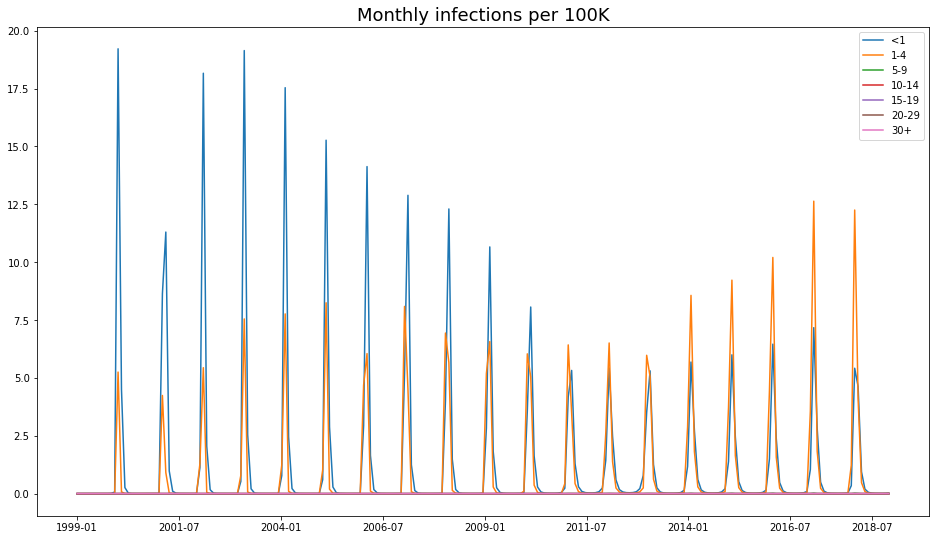

In [16]:
beta = np.eye(7)*np.maximum(fit_measles[0],0.0025)

mdl = m.SIRVModel(para, lambda t: beta)
ic = estimate_SIR_IC(mdl, age_struct_start, pop_scale, V_ic)

eval_year = 120
out, t, out_YN = mdl.run(ic ,t_max = years_run-0.00001, method="RK45", eval_per_year=eval_year, pop_scale=pop_scale, 
                         atol=1e-6, rtol = 1e-4)

plt.figure(figsize=(16,9))
for ii in range(7):
    plt.plot(np.linspace(0,years_run, years_run*12)[0:-1], 
             (1e5/pop_scale)*np.transpose(get_monthly_rates(out_YN, eval_year, years_run)[ii,:]), label = age_class[ii])

locs, labels = plt.xticks()
locs = np.hstack([locs[1:-2], 19.5])
plt.xticks(locs, time_date[locs*12])
plt.legend()
plt.title("Monthly infections per 100K", fontsize = 18)

In [17]:
fit_measles[0]

array([0.0077182 , 0.14214992, 0.21380122, 0.24281186, 0.20576573,
       0.23221351, 0.27200709])